In [3]:

import os 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
#from statannot import add_stat_annotation
import scanpy as sc
import anndata as ad
import itertools
import episcanpy.api as epi
import gseapy
from sklearn.decomposition import NMF
import sankey
from matplotlib import cm
#from clusteringMethods import *
%matplotlib inline 

In [4]:
model_path = "../cellformer/deconvoluted/"
data = "../data/deconvoluted_ct.h5ad"
savepath = model_path
string = savepath + "string/"

In [7]:
### change the cell type to INH
ct = "OLD"
ba= "hipp"
spath = os.path.join(string, ct+"_"+ba)
network = pd.read_csv(spath +"/string_interactions.tsv", sep="\t")
network

network[(network["#node1"]=="NOX4") & (network["node2"]=="ZNF16")]
annota = pd.read_csv(spath  +"/string_mapping.tsv", sep="\t")
annota
map_stringID2query = {ss:qq for ss,qq in zip(annota["preferredName"].values, annota["queryItem"].values)}
homer_ = pd.read_csv(spath  +"/TF_enr_%s.csv"%ct)
homer_["-log(q-value)"] = -np.log(homer_["q-value (Benjamini)"].values)
homer_ = homer_[homer_["-log(q-value)"] >-np.log(0.01)]
map_query2Q = {qq:lq for qq,lq in zip(homer_["TF_name_"].values,homer_["-log(q-value)"] )}
map_query2Per = {qq:lq for qq,lq in zip(homer_["TF_name_"].values,homer_["Percentage of Target Sequences with Motif"] )}
network["node1_query"] = network["#node1"].map(map_stringID2query).values
network["node1_qval"] = network["node1_query"].map(map_query2Q).values
network["node1_percent"] = network["node1_query"].map(map_query2Per).values

  
nod_toadd = [it for it in homer_["TF_name_"].values if it not in network["node1_query"].values]
len(nod_toadd)

9

In [8]:
network = network[network.node1_qval >-np.log(0.01)]
network = network[network.node2.isin(network["#node1"].values.tolist())]

ZNF768
ZNF382
ZNF675
Ascl2
LRF
ARE
Barx1
TCFL2
EBNA
RARg
HRE


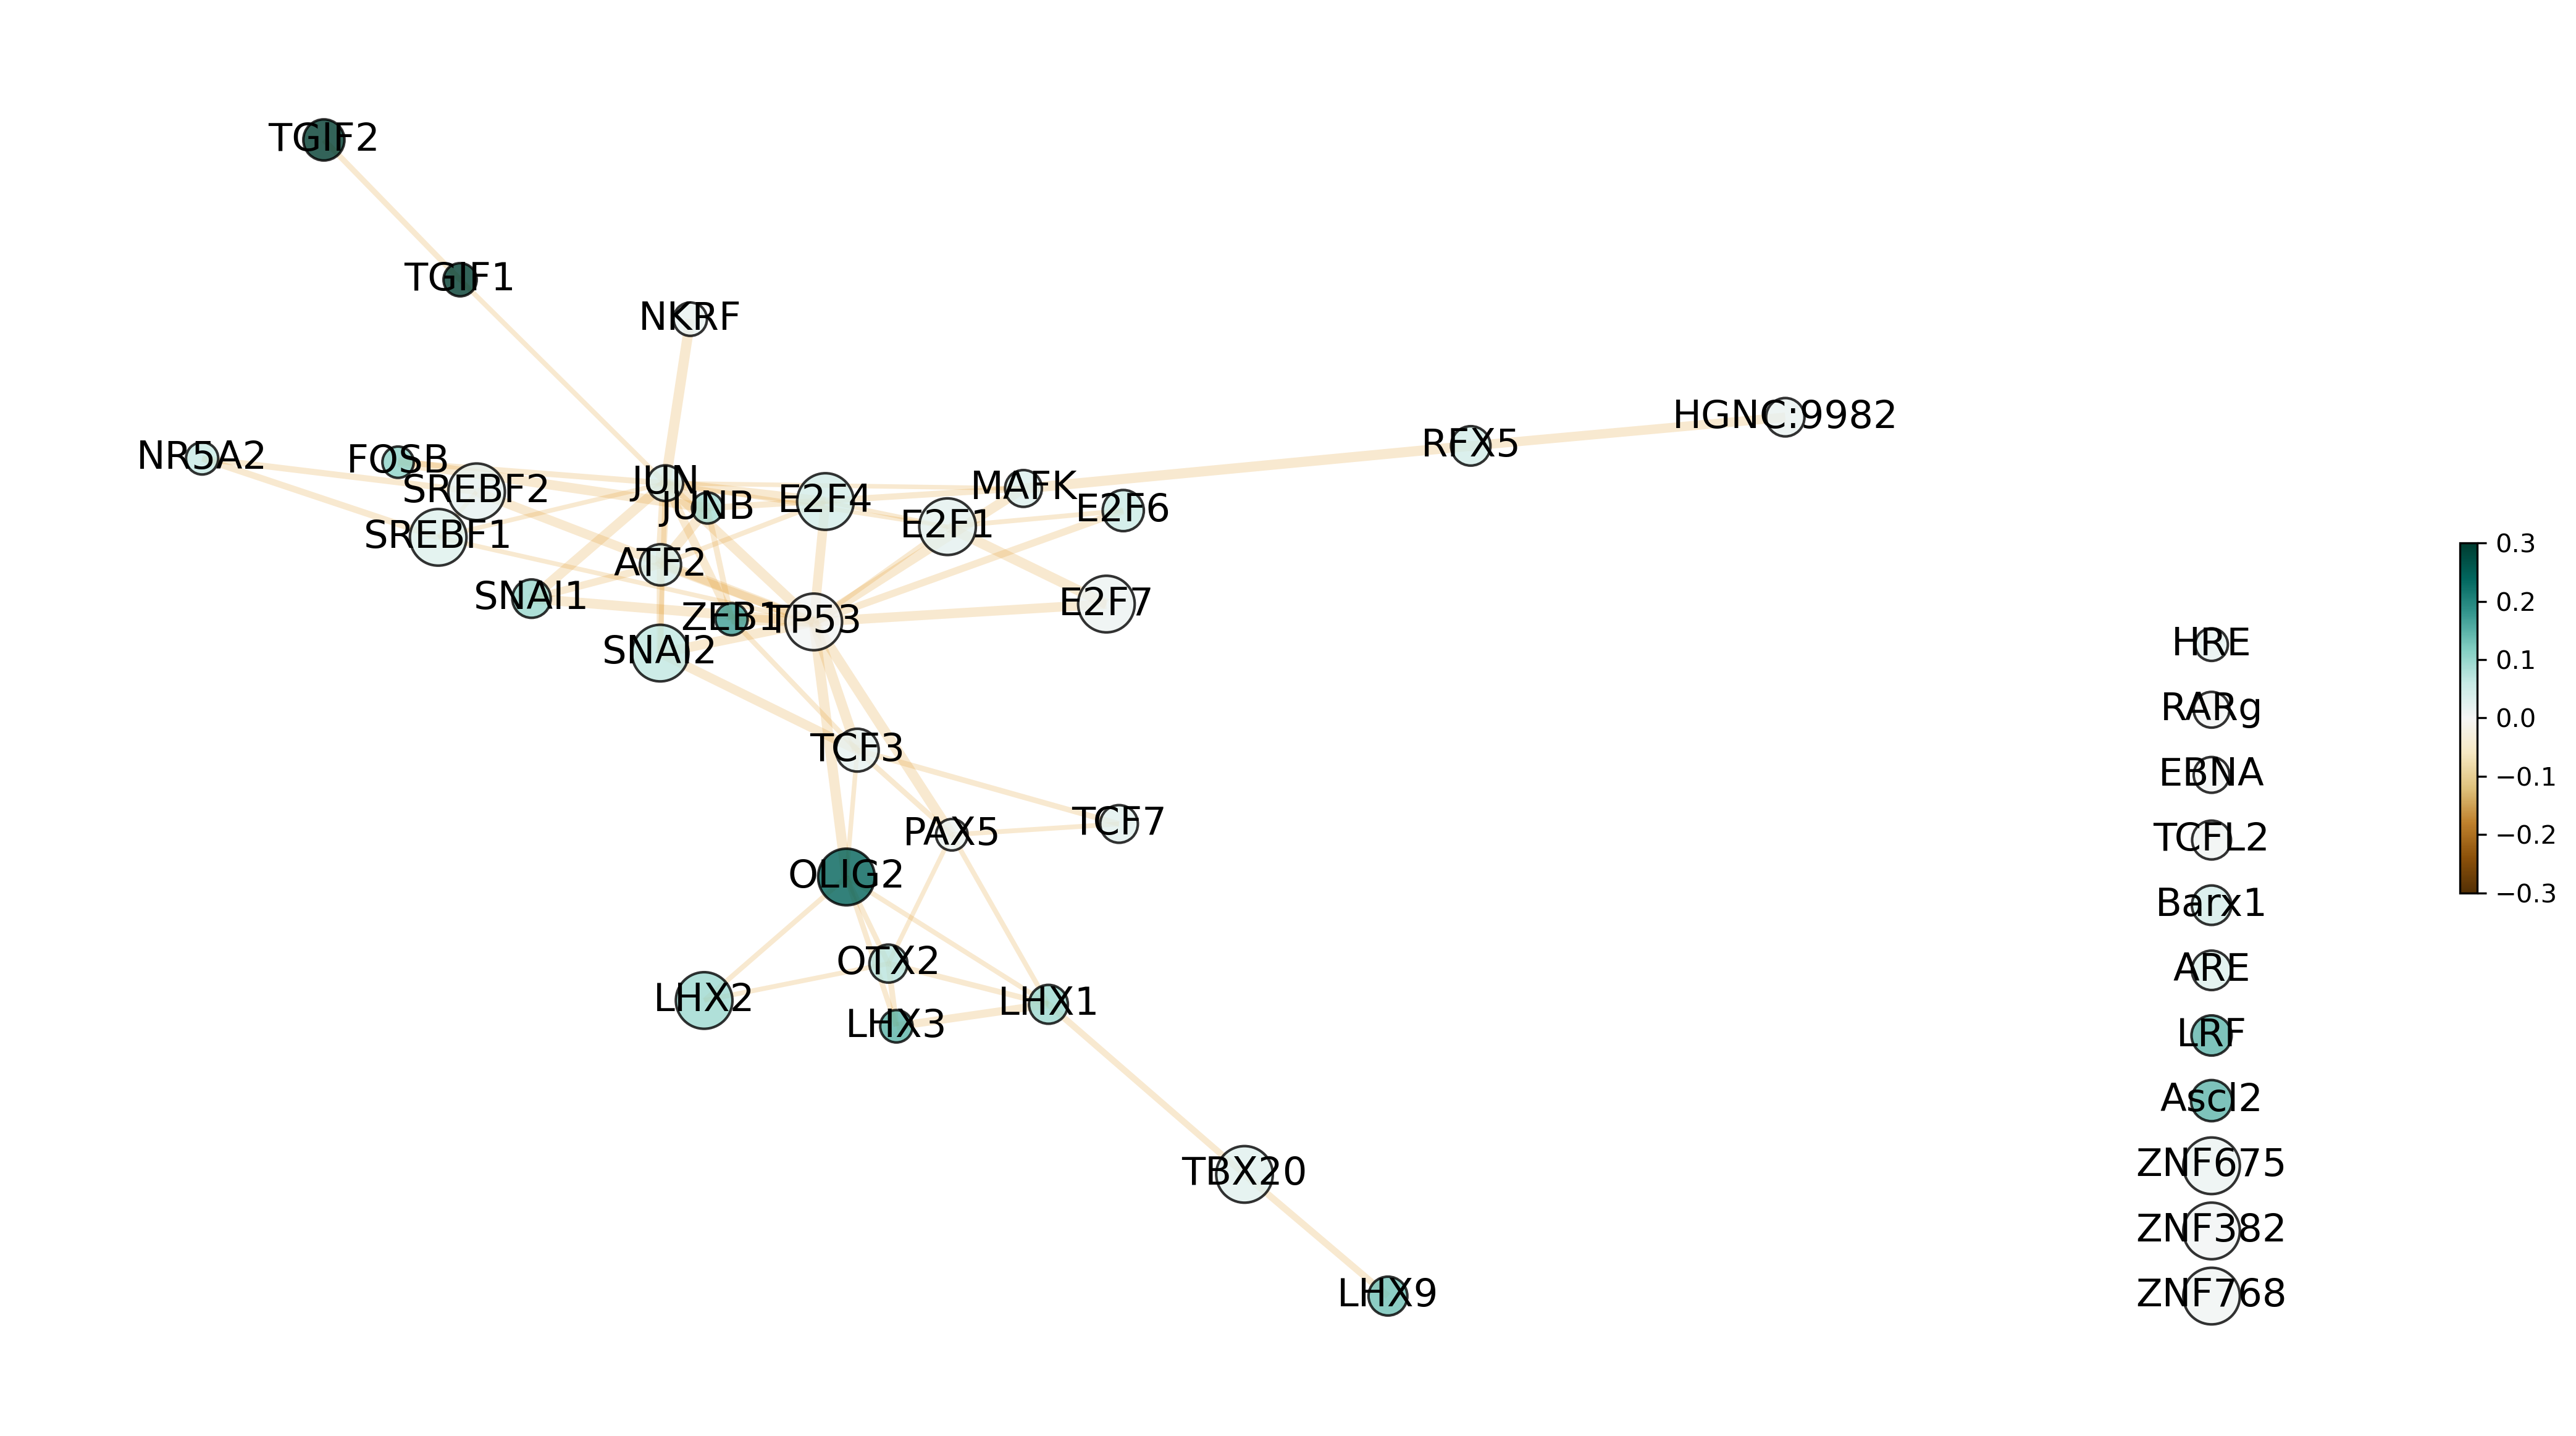

In [12]:
import networkx as nx
import matplotlib as mpl
import sszpalette
colorsmaps = sszpalette.register()
seed=6
G = nx.from_pandas_edgelist(network, "#node1", "node2", ["combined_score"])
nod_toadd = [it for it in homer_["TF_name_"].values if it not in network["node1_query"].values if str(it)!="nan"]

pos = nx.spring_layout(G, seed=seed, scale=10)
G.add_nodes_from(nod_toadd)
min_pos1 =np.min([it[1][1] for it in pos.items()])
min_pos0 =np.max([it[1][0] for it in pos.items()])
for k,it in enumerate(nod_toadd):
    pos[it] = np.array([ min_pos0+3, min_pos1+k])
    print(it)
    map_stringID2query[it] = it
fig = plt.figure(1, figsize=(20, 10), dpi=300)
#map_node2size = {nn:qq for nn,qq in zip(G.nodes, homer_["-log(q-value)"].values)}
#map_node2color = {nn:qq for nn, qq in zip(G.nodes, network["node1_percent"].values)}
map_edge2width = {(nn1, nn2):qq for (nn1, nn2), qq in zip(G.edges,
                                                             network["combined_score"].values)}
cmap = plt.get_cmap("BrBG")
node_color =[map_query2Per[map_stringID2query[it]]/100. for it in G.nodes] 
node_size=[map_query2Q[map_stringID2query[it]]*30 for it in G.nodes],
nodes = nx.draw_networkx_nodes(G,pos,
                        node_size=node_size,
                        node_color=node_color,
                        edgecolors="#aaaaaa",
                        alpha=0.8,
                        vmin=-0.3,
                        vmax=0.3,
                        cmap=cmap)
edges_width = [map_edge2width[it]*4 for it in G.edges]
edges = nx.draw_networkx_edges(G,
                                pos,
                                node_size=node_size,
                                width=edges_width,
                                edge_color="#df9114",
                                alpha=0.2,
                                
                                )
label = nx.draw_networkx_labels(G, pos, 
                                labels={it:it for it in G.nodes},
                                 font_color="black", #"#df9114", 
                                 #font_weight="bold",
                                 bbox={"facecolor":"None", "edgecolor":"None"},
                                font_size=15)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -0.3, vmax=0.3))
sm._A = []

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(sm, ax=ax, shrink=0.25)
plt.savefig(spath + "/network_draw.svg")
plt.show()